In [1]:
import pandas as pd
import re
import os
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
os.chdir(r'C:\Users\ferzi\python practice\Car price prediction with XGBoost')
df = pd.read_csv(r'car_price_prediction.csv')
print(df.shape)
print(df.info())
print(df.isna().any())
df.head()

(19236, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19236 entries, 0 to 19235
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19236 non-null  int64  
 1   Price             19236 non-null  int64  
 2   Levy              19236 non-null  object 
 3   Manufacturer      19236 non-null  object 
 4   Model             19236 non-null  object 
 5   Prod. year        19236 non-null  int64  
 6   Category          19236 non-null  object 
 7   Leather interior  19236 non-null  object 
 8   Fuel type         19236 non-null  object 
 9   Engine volume     19236 non-null  object 
 10  Mileage           19236 non-null  object 
 11  Cylinders         19236 non-null  float64
 12  Gear box type     19236 non-null  object 
 13  Drive wheels      19236 non-null  object 
 14  Doors             19236 non-null  object 
 15  Wheel             19236 non-null  object 
 16  Color             19236 non-

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
df.drop('ID', axis = 1, inplace = True)
df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19231,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19232,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19233,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19234,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


In [4]:
df.describe()

,Price,Prod. year,Cylinders,Airbags
count,1.923600e+04,19236.000000,19236.000000,19236.000000
mean,1.855603e+04,2010.912872,4.583021,6.582710
std,1.905862e+05,5.668817,1.199957,4.320266
min,1.000000e+00,1939.000000,1.000000,0.000000
25%,5.331000e+03,2009.000000,4.000000,4.000000
50%,1.317200e+04,2012.000000,4.000000,6.000000
75%,2.208275e+04,2015.000000,4.000000,12.000000
max,2.630750e+07,2020.000000,16.000000,16.000000


In [5]:
# In collecting the data set from a variety of used car dealerships, 
# the data set also included higher end luxury dealerships which sold cars such as Bentleys and Lamborghinis. 
# In order to understand whether or not we should include them in our data set, 
# we need to identify the top 3 car manufacturers with the highest average (mean) sales price.

df.groupby("Manufacturer")["Price"].mean().nlargest(3)


Manufacturer
LAMBORGHINI    872946.000000
BENTLEY        197574.500000
OPEL            73305.617128
Name: Price, dtype: float64

In [6]:
# Currently some columns are not in a numerical format, 
# meaning you should convert them before using them in a machine learning model such as XGBoost. 
# Take a look at the "Mileage" column in the dataset and clean it 
# by removing the "km" substring to get numerical values as strings, then convert these strings to a float data type.

df['Mileage'].replace('km', '' , regex = True, inplace=True)
df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19231,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19232,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19233,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19234,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258,4.0,Automatic,Front,04-May,Left wheel,Black,4


In [7]:
df['Mileage'] = df['Mileage'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19236 entries, 0 to 19235
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19236 non-null  int64  
 1   Levy              19236 non-null  object 
 2   Manufacturer      19236 non-null  object 
 3   Model             19236 non-null  object 
 4   Prod. year        19236 non-null  int64  
 5   Category          19236 non-null  object 
 6   Leather interior  19236 non-null  object 
 7   Fuel type         19236 non-null  object 
 8   Engine volume     19236 non-null  object 
 9   Mileage           19236 non-null  float64
 10  Cylinders         19236 non-null  float64
 11  Gear box type     19236 non-null  object 
 12  Drive wheels      19236 non-null  object 
 13  Doors             19236 non-null  object 
 14  Wheel             19236 non-null  object 
 15  Color             19236 non-null  object 
 16  Airbags           19236 non-null  int64 

In [8]:
df['Levy'].replace('-', '0', regex = True, inplace = True)

In [9]:
df['Levy'] = df['Levy'].astype('int64')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19236 entries, 0 to 19235
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19236 non-null  int64  
 1   Levy              19236 non-null  int64  
 2   Manufacturer      19236 non-null  object 
 3   Model             19236 non-null  object 
 4   Prod. year        19236 non-null  int64  
 5   Category          19236 non-null  object 
 6   Leather interior  19236 non-null  object 
 7   Fuel type         19236 non-null  object 
 8   Engine volume     19236 non-null  object 
 9   Mileage           19236 non-null  float64
 10  Cylinders         19236 non-null  float64
 11  Gear box type     19236 non-null  object 
 12  Drive wheels      19236 non-null  object 
 13  Doors             19236 non-null  object 
 14  Wheel             19236 non-null  object 
 15  Color             19236 non-null  object 
 16  Airbags           19236 non-null  int64 

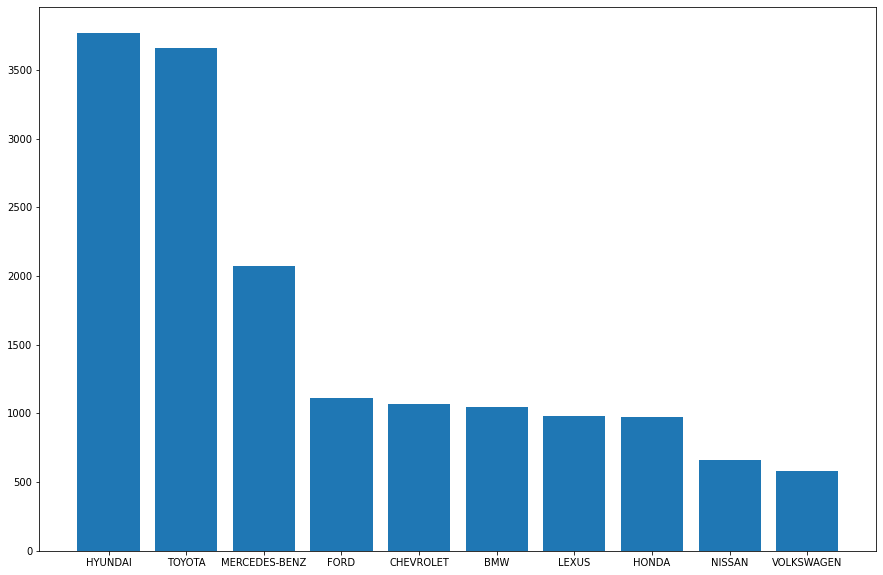

In [13]:
import matplotlib.pyplot as plt

# 2. Calculate the top 10 most popular manufacturers in the data set using value_counts()

top_ten_manufacturers = df["Manufacturer"].value_counts().nlargest(10)

# 3. Use the results of value_counts() to create the bar plot
plt.figure(figsize=(15, 10))
plt.bar(x=top_ten_manufacturers.keys(), height=top_ten_manufacturers.values, );

##### PLEASE NOTE THAT THIS ANALYSIS IS INCOMPLETE. Will be completed at a later date